In [1]:
import sys
from logging import Logger
from pathlib import Path
from typing import Optional, List

import IPython
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import RobustScaler
import tqdm
from itertools import product

NOTEBOOK_PATH: Path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
PROJECT_DIR: Path = NOTEBOOK_PATH.parent.parent
sys.path.append(str(PROJECT_DIR))
import src.utils.custom_log as custom_log

LOG: Logger = custom_log.init_logger(__name__, log_lvl=custom_log.LEVELS.INFO)
LOG.info("Log start, project directory is %s (exist: %s)", PROJECT_DIR, PROJECT_DIR.is_dir())

2024-07-05 13:16:15,217 MainProcess - MainThread INFO Log start, project directory is /root/py_projects/aihiii (exist: True) || 3058257952.py


In [2]:
DATA_DIR: Path = PROJECT_DIR / "data" / "raw" / "doe_big_grid_20230922_154140"
LOG.info("Data directory is %s (exist: %s)", DATA_DIR, DATA_DIR.is_dir())

AI_DIR: Path = PROJECT_DIR / "experiments" / "2024-07-05-07-45-58_trial_doe_from_fe"
LOG.info("AI directory is %s (exist: %s)", AI_DIR, AI_DIR.is_dir())

PIC_DIR:Path = PROJECT_DIR / "reports" / "figures" / NOTEBOOK_PATH.stem
PIC_DIR.mkdir(parents=True, exist_ok=True)
LOG.info("Picture directory is %s (exist: %s)", PIC_DIR, PIC_DIR.is_dir())

2024-07-05 13:16:15,227 MainProcess - MainThread INFO Data directory is /root/py_projects/aihiii/data/raw/doe_big_grid_20230922_154140 (exist: True) || 3877948236.py
2024-07-05 13:16:15,229 MainProcess - MainThread INFO AI directory is /root/py_projects/aihiii/experiments/2024-07-05-07-45-58_trial_doe_from_fe (exist: True) || 3877948236.py
2024-07-05 13:16:15,230 MainProcess - MainThread INFO Picture directory is /root/py_projects/aihiii/reports/figures/prediction_insight_fe2doe (exist: True) || 3877948236.py


In [3]:
RNG: np.random.Generator = np.random.default_rng(seed=42)
PERCENTILE: int = 50

In [4]:
DOE: pd.DataFrame = pd.read_parquet(DATA_DIR / "doe.parquet", filters=[("PERC", "==", PERCENTILE)])
DOE.drop(columns=["PERC"], inplace=True)
DOE

,PAB_M_Scal,PAB_Vent_T,Pulse_Angle,Pulse_X_Scale,SLL
SIM_ID,,,,,
15627,0.9,0.07,-10,0.8,2140
15632,0.9,0.07,-10,0.8,2240
15637,0.9,0.07,-10,0.8,2340
15642,0.9,0.07,-10,0.8,2440
15647,0.9,0.07,-10,0.8,2540
...,...,...,...,...,...
31227,1.1,0.13,10,1.2,2140
31232,1.1,0.13,10,1.2,2240
31237,1.1,0.13,10,1.2,2340


In [5]:
CHANNELS: pd.DataFrame = pd.read_parquet(DATA_DIR / "channels.parquet", filters=[("SIM_ID", "in", set(DOE.index))])
CHANNELS

03CHST0000OCCUACXD  03CHST0000OCCUACYD  03CHST0000OCCUACZD  \
SIM_ID TIME                                                                
15627  0.0                 0.000               0.000               0.000   
       0.1                -0.025              -0.006               0.198   
       0.2                -0.063              -0.014               0.250   
       0.3                -0.103              -0.021               0.301   
       0.4                -0.144              -0.029               0.351   
...                          ...                 ...                 ...   
31247  139.6               4.200              -1.208               0.370   
       139.7               4.172              -1.185               0.370   
       139.8               4.146              -1.165               0.369   
       139.9               4.124              -1.146               0.370   
       140.0               4.104              -1.130               0.370   

              03HEAD0000OCCUACXD  03HEAD0000OCCUACYD  03HEAD0000OCCUACZD  \
SIM_ID TIME                                                                
15627  0.0                 0.000               0.000               0.000   
       0.1                -0.120              -0.004               0.202   
       0.2                -0.142              -0.013               0.243   
       0.3                -0.164              -0.021               0.283   
       0.4                -0.187              -0.028               0.323   
...                          ...                 ...                 ...   
31247  139.6              -3.019               3.743               0.837   
       139.7              -2.996               3.753               0.884   
       139.8              -2.977               3.763               0.929   
       139.9              -2.960               3.770               0.969   
       140.0              -2.946               3.777               1.006   

              03PELV0000OCCUACXD  03PELV0000OCCUACYD  03PELV0000OCCUACZD  \
SIM_ID TIME                                                                
15627  0.0                 0.000               0.000               0.000   
       0.1                 0.076              -0.006              -0.115   
       0.2                 0.014              -0.013              -0.216   
       0.3                -0.047              -0.021              -0.315   
       0.4                -0.105              -0.028              -0.410   
...                          ...                 ...                 ...   
31247  139.6               8.024              -3.440               3.131   
       139.7               8.049              -3.468               3.126   
       139.8               8.071              -3.493               3.121   
       139.9               8.089              -3.514               3.116   
       140.0               8.106              -3.533               3.112   

              03FEMRLE00OCCUFOXD  ...  03CHSTLOLEOCCUFORD  03CHSTUPRIOCCUFORD  \
SIM_ID TIME                       ...                                           
15627  0.0                 0.000  ...               0.000               0.000   
       0.1                -0.259  ...               0.000               0.000   
       0.2                -0.199  ...               0.000               0.000   
       0.3                -0.143  ...               0.000               0.000   
       0.4                -0.089  ...               0.000               0.000   
...                          ...  ...                 ...                 ...   
31247  139.6               0.032  ...               0.054               0.079   
       139.7               0.030  ...               0.054               0.079   
       139.8               0.029  ...               0.054               0.079   
       139.9               0.028  ...               0.054               0.080   
       140.0               0.027  ...               0.054               0.0

In [6]:
INJURY_VALUES: pd.DataFrame = pd.read_parquet(DATA_DIR / "injury_criteria.parquet", filters=[("SIM_ID", "in", set(DOE.index))])
INJURY_VALUES

,Head_HIC15,Head_HIC36,Head_a3ms,Neck_Nij,Neck_Fz_Max_Compression,Neck_Fz_Max_Tension,Neck_My_Max,Neck_Fx_Shear_Max,Chest_Deflection,Chest_a3ms,Femur_Fz_Max
SIM_ID,,,,,,,,,,,
15627,109.962,206.273,36.271,0.380,0.023,1.341,56.634,0.816,27.110,39.769,3.988
15632,118.008,223.931,37.375,0.415,0.076,1.410,64.354,0.910,24.983,41.627,3.948
15637,131.999,229.098,39.794,0.426,0.154,1.390,68.620,0.964,25.728,41.505,3.983
15642,130.705,227.353,39.245,0.425,0.117,1.415,67.256,0.913,28.824,42.691,3.999
15647,149.546,244.733,41.846,0.442,0.127,1.537,67.045,1.089,26.337,43.495,3.993
...,...,...,...,...,...,...,...,...,...,...,...
31227,539.157,607.558,74.385,0.609,0.067,1.008,142.957,2.041,33.610,57.157,6.181
31232,485.223,541.359,72.804,0.533,0.217,0.960,121.556,1.898,34.619,58.471,6.091
31237,482.006,579.108,69.787,0.498,0.066,0.800,118.023,1.853,36.234,57.894,6.149


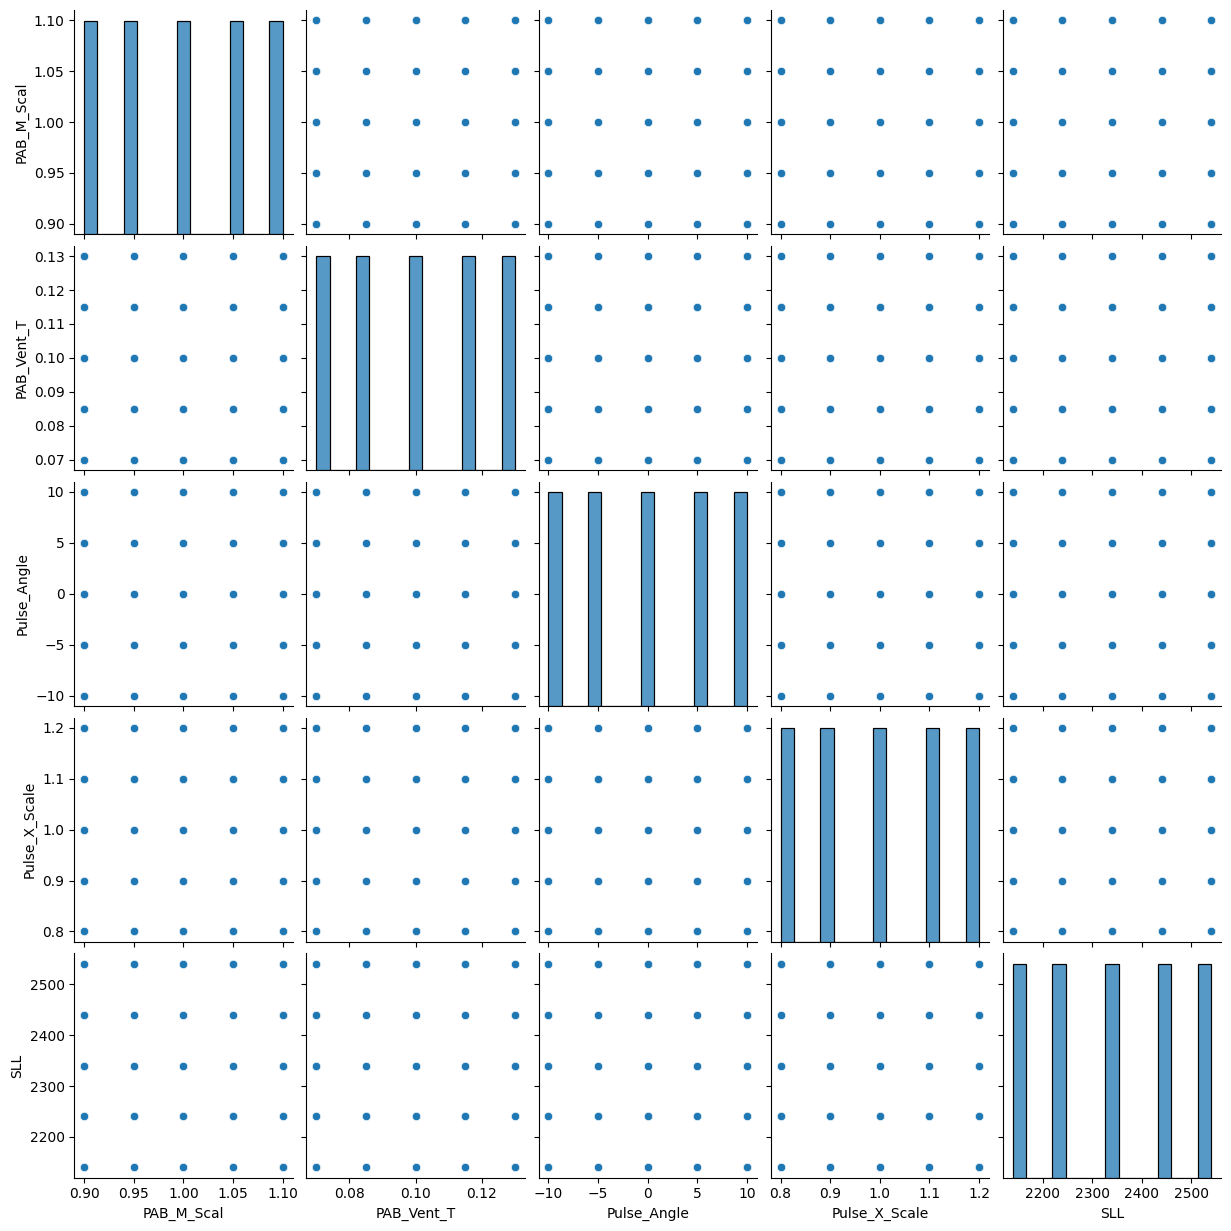

In [7]:
sns.pairplot(DOE);

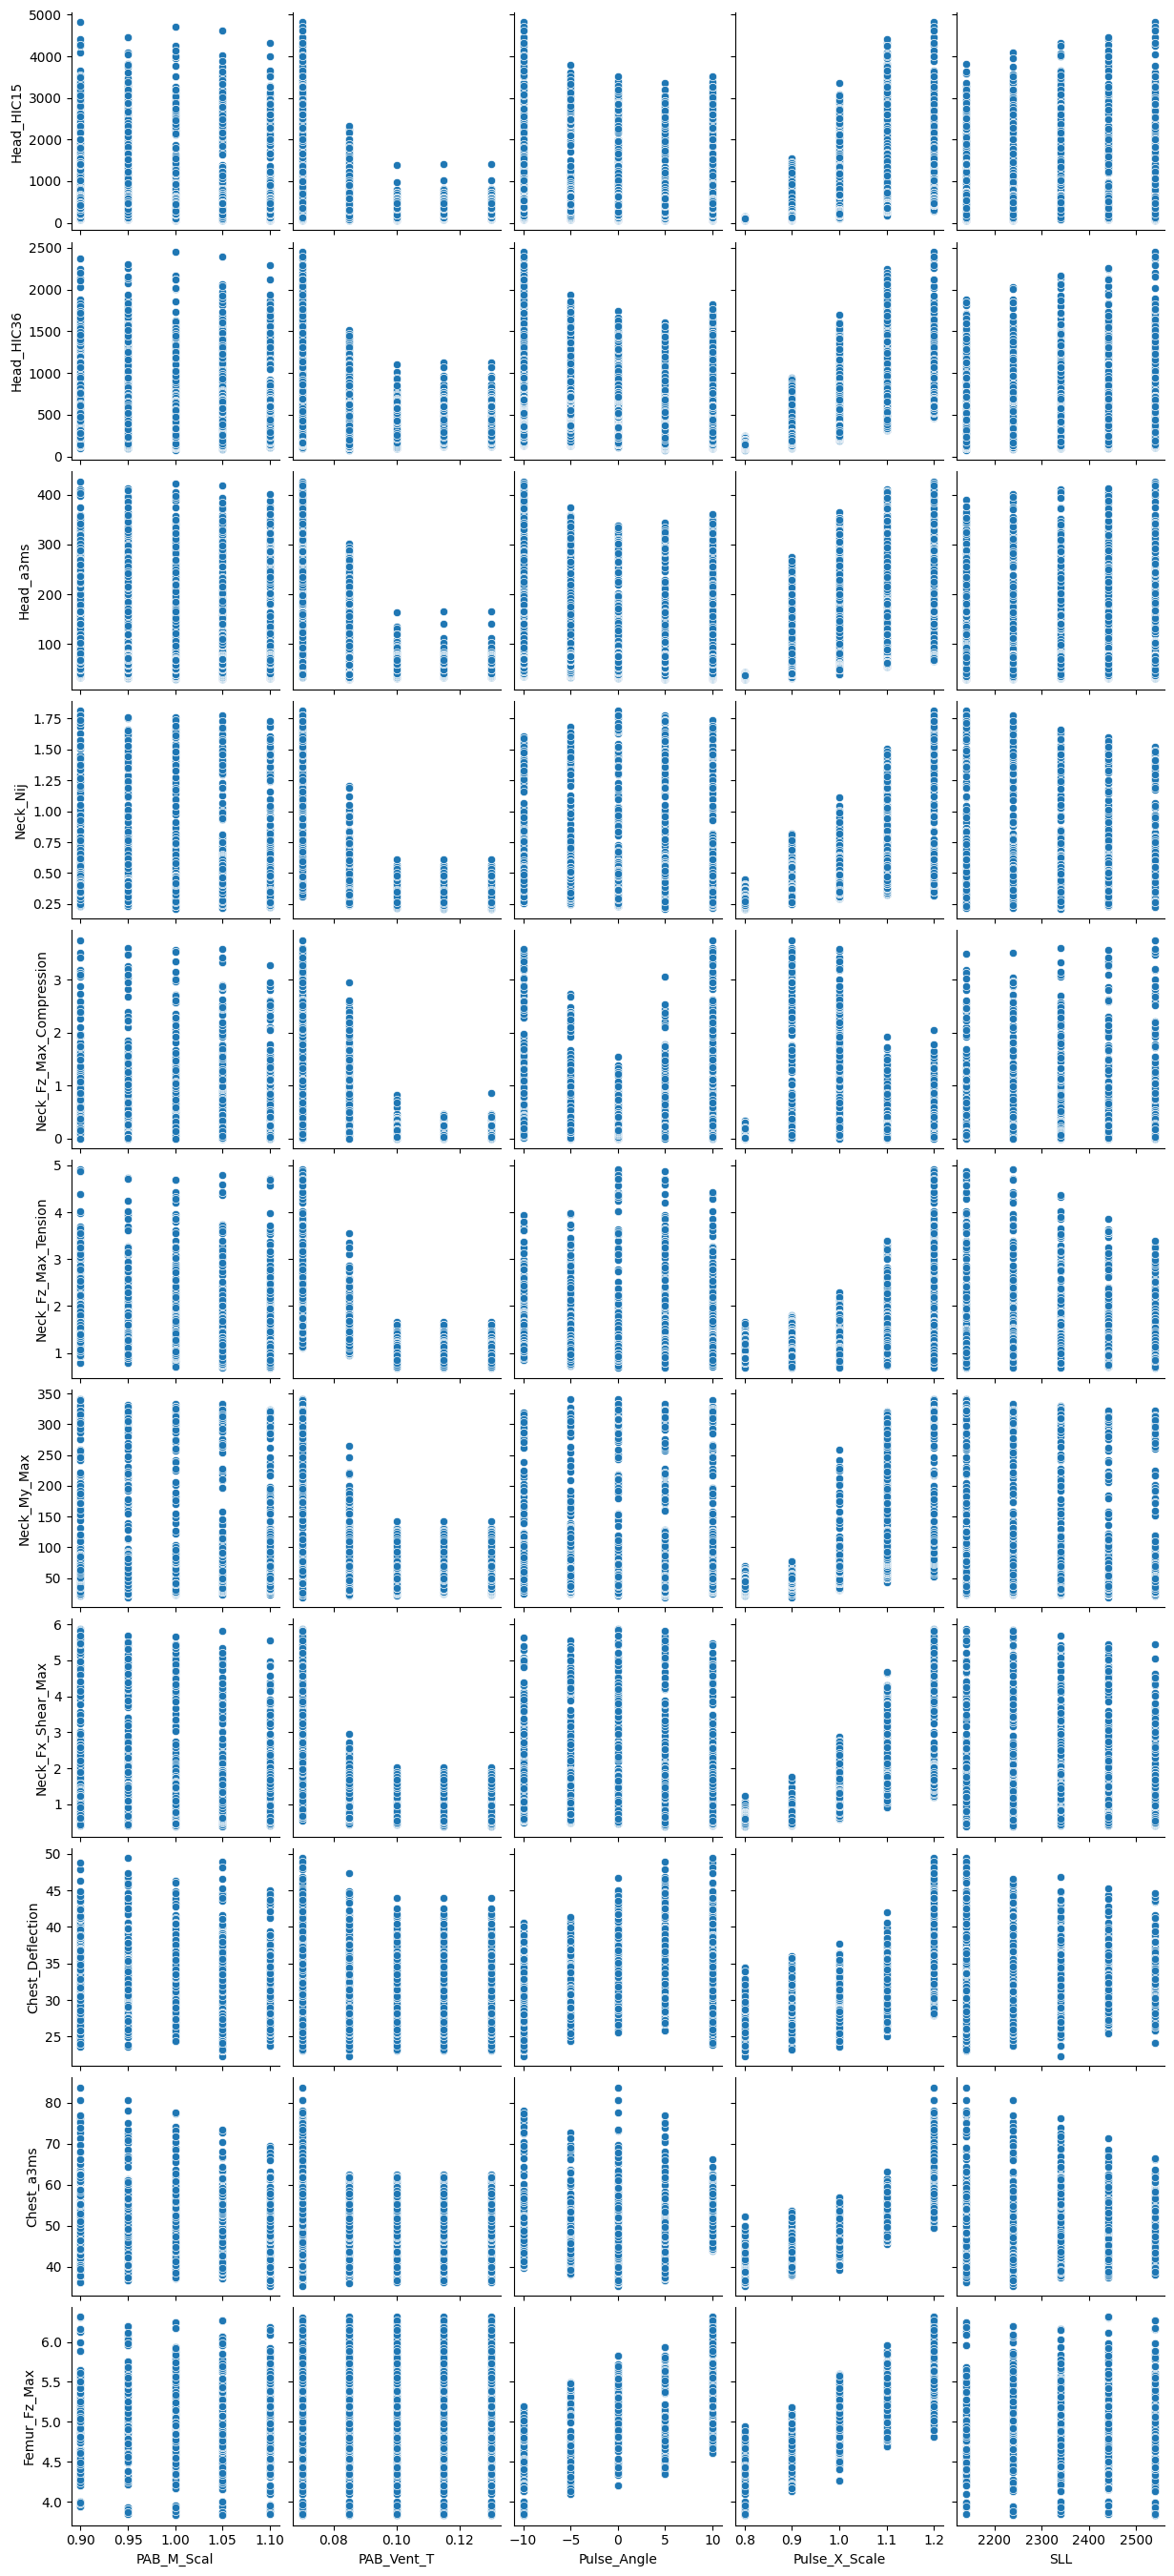

In [8]:
sns.pairplot(pd.concat([DOE, INJURY_VALUES], axis=1), x_vars=DOE.columns, y_vars=INJURY_VALUES.columns);

2024-07-05 13:16:31,946 MainProcess - MainThread INFO Plotting channel 03CHST0000OCCUACXD || 427232614.py


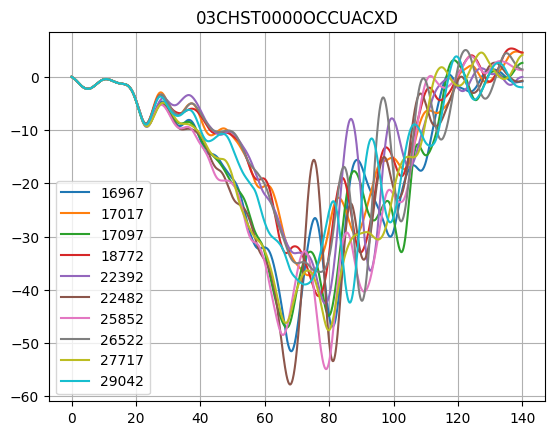

In [9]:
def plot_channel(channel: str, ax: Optional[Axes] = None, n_samples: int = 10, choose_from: Optional[List[int]] = None) -> None:
    LOG.info("Plotting channel %s", channel)
    # init plot
    if ax is None:
        _, ax = plt.subplots()

    # selection
    if choose_from is None:
        choose_from = sorted(DOE.index)
    samples = sorted(RNG.choice(choose_from, n_samples))

    # plot
    for idx in samples:
        data = CHANNELS.loc[(idx, slice(None)), channel]
        ax.plot(data.index.get_level_values("TIME"), data.values, label=idx)

    # format
    ax.grid()
    ax.legend()
    ax.set_title(channel)


plot_channel("03CHST0000OCCUACXD")

2024-07-05 13:16:32,455 MainProcess - MainThread INFO Plotting channel 03CHST0000OCCUACXD conditional on PAB_M_Scal || 1828170959.py
2024-07-05 13:16:32,509 MainProcess - MainThread INFO Plotting channel 03CHST0000OCCUACXD || 427232614.py
2024-07-05 13:16:32,540 MainProcess - MainThread INFO Plotting channel 03CHST0000OCCUACXD || 427232614.py
2024-07-05 13:16:32,570 MainProcess - MainThread INFO Plotting channel 03CHST0000OCCUACXD || 427232614.py
2024-07-05 13:16:32,604 MainProcess - MainThread INFO Plotting channel 03CHST0000OCCUACXD || 427232614.py
2024-07-05 13:16:32,640 MainProcess - MainThread INFO Plotting channel 03CHST0000OCCUACXD || 427232614.py
2024-07-05 13:16:32,670 MainProcess - MainThread INFO Done || 1828170959.py


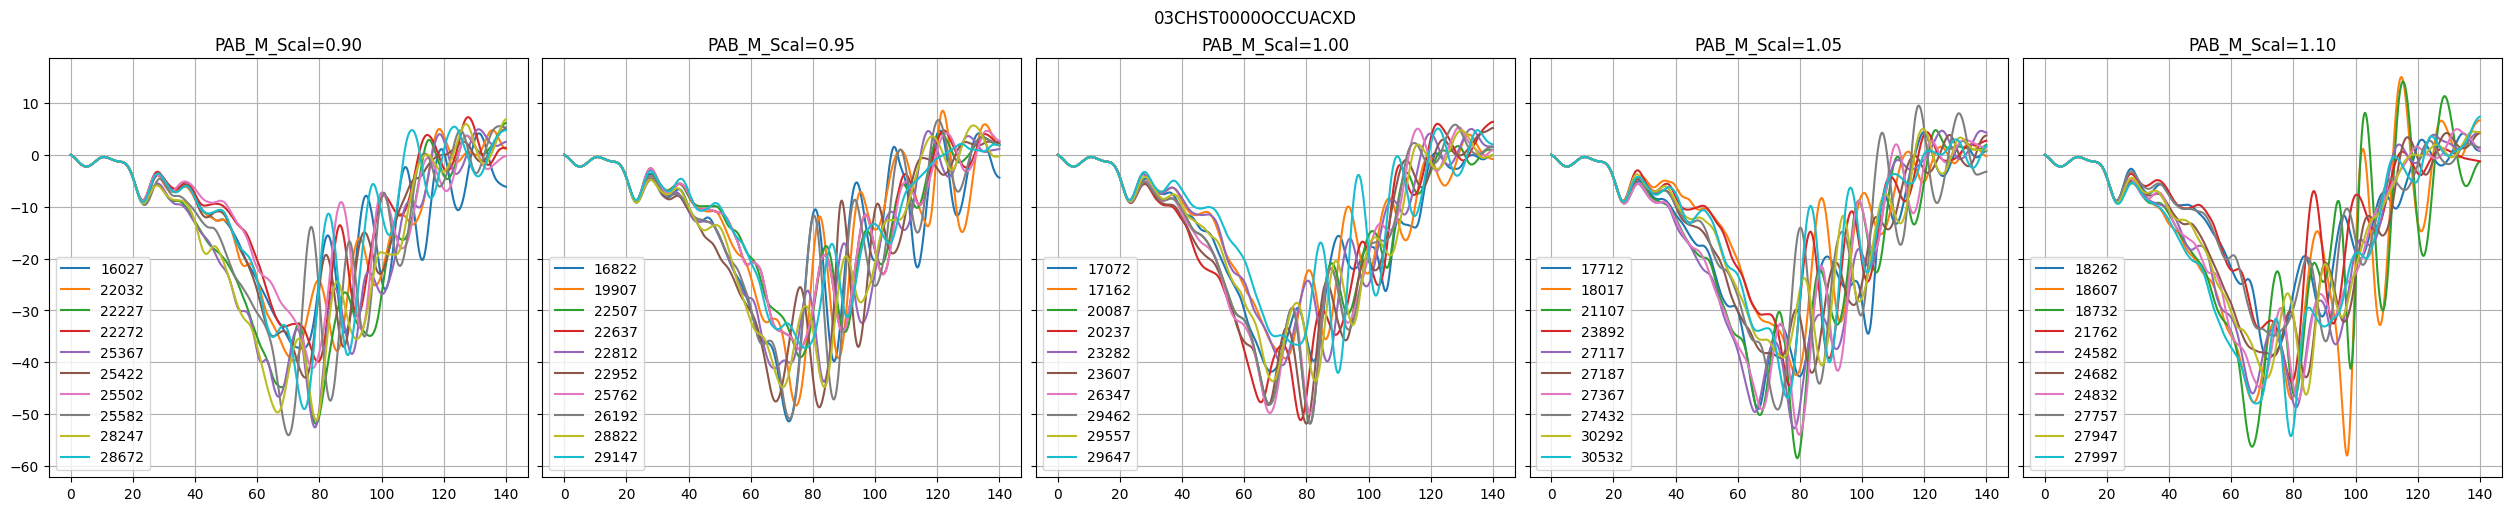

In [10]:
def plot_channel_conditional_doe(factor: str, channel: str, store: Optional[bool] = False) -> None:
    LOG.info("Plotting channel %s conditional on %s", channel, factor)

    factor_values = DOE[factor].unique()
    fig, ax = plt.subplots(ncols=len(factor_values), sharex=True, sharey=True, figsize=(25, 5), layout="constrained")
    for i, factor_value in enumerate(factor_values):
        plot_channel(
            channel=channel,
            ax=ax[i],
            choose_from=sorted(DOE[DOE[factor].eq(factor_value)].index),
        )
        ax[i].set_title(f"{factor}={factor_value:.2f}")
    fig.suptitle(channel)

    if store:
        pic_path = PIC_DIR / "channel_conditional_doe" / f"{channel}_{factor}.png"
        pic_path.parent.mkdir(parents=True, exist_ok=True)
        LOG.info("Saving picture to %s", pic_path)
        fig.savefig(pic_path)
        plt.close(fig)

    LOG.info("Done")


plot_channel_conditional_doe(factor="PAB_M_Scal", channel="03CHST0000OCCUACXD")

In [11]:
LOG.setLevel(custom_log.LEVELS.WARNING)
for channel, factor in tqdm.tqdm(list(product(CHANNELS.columns, DOE.columns))):
    plot_channel_conditional_doe(factor=factor, channel=channel, store=True)
LOG.setLevel(custom_log.LEVELS.INFO)

100%|██████████| 335/335 [04:48<00:00,  1.16it/s]


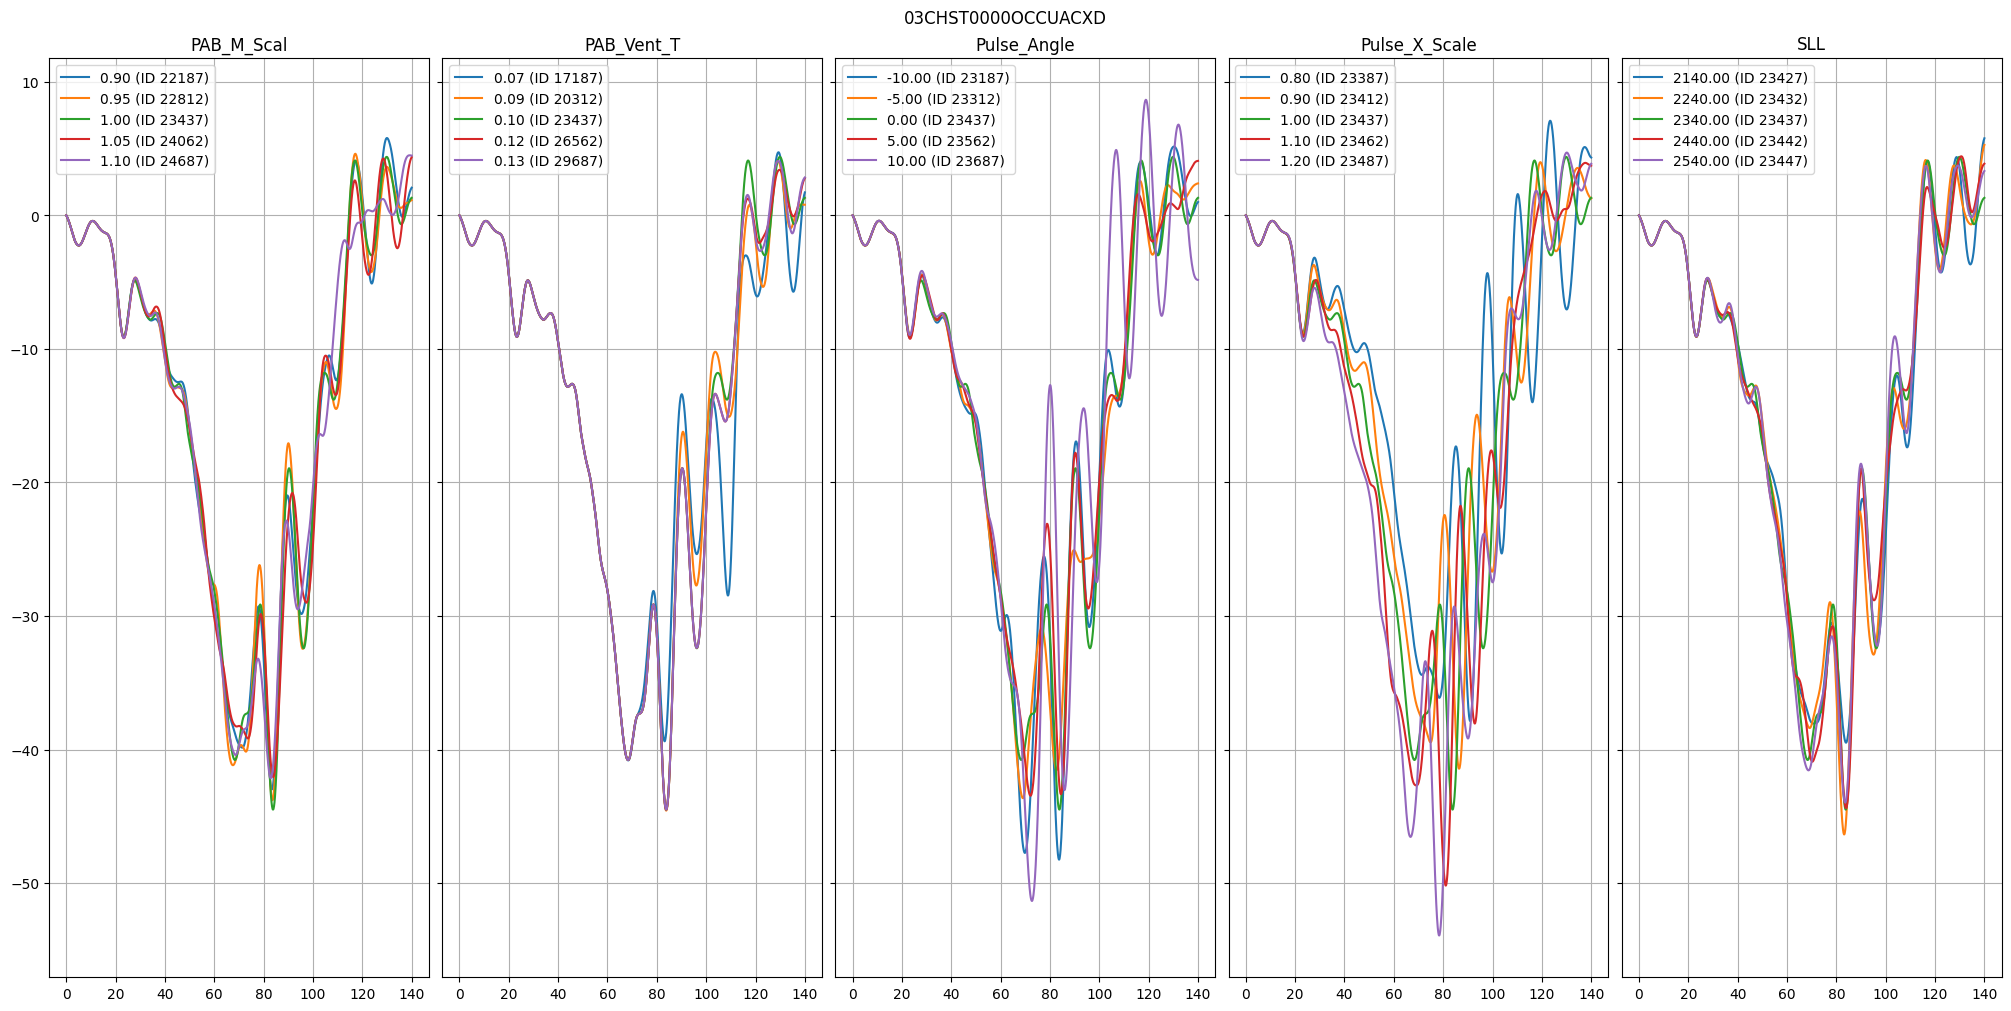

In [12]:
def plot_parameter_influence(channel: str, para_pos: int = 2, store: bool = False) -> None:
    fig, ax = plt.subplots(ncols=len(DOE.columns), figsize=(20, 10), sharex=True, sharey=True, layout="constrained")
    fig.suptitle(channel)

    for i, col in enumerate(DOE.columns):
        remaining = set(DOE.columns) - {col}
        filt = DOE[col].le(1e20)
        for other_col in remaining:
            filt &= DOE[other_col].eq(sorted(DOE[other_col].unique())[para_pos])

        for idx in DOE[filt].index:
            ch_data = CHANNELS.loc[(idx, slice(None)), channel]
            ax[i].plot(ch_data.index.get_level_values("TIME"), ch_data.values, label=f"{DOE.loc[idx, col]:.2f} (ID {idx})")
        ax[i].set_title(col)
        ax[i].grid()
        ax[i].legend()

    if store:
        pic_path = PIC_DIR / "plot_parameter_influence" / f"{channel}.png"
        pic_path.parent.mkdir(parents=True, exist_ok=True)
        LOG.info("Saving picture to %s", pic_path)
        fig.savefig(pic_path)
        plt.close(fig)

plot_parameter_influence("03CHST0000OCCUACXD")

In [13]:
LOG.setLevel(custom_log.LEVELS.WARNING)
for ch in tqdm.tqdm(CHANNELS.columns):
    plot_parameter_influence(channel=ch, store=True)
LOG.setLevel(custom_log.LEVELS.INFO)

100%|██████████| 67/67 [00:45<00:00,  1.46it/s]
